# Kafka Customer - Model Performace and Retraining

A notebook that is used on the local machine to connect to the Kafka server and act as the consumer.

---

##### Libraries

In [90]:
# Libraries in the Consumer Notebook

# General
import time
import os
import sys

# Data manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# SQL
import pymysql
import mysql.connector

# Data types
import json
import joblib

# Avro objects
import io
import fastavro
import avro

# Kafka
from confluent_kafka import Consumer, KafkaException, KafkaError

# Machine Learning Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans # used to partial retrain models

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, silhouette_score

from skmultiflow.trees import HoeffdingTree

In [57]:
import warnings
warnings.filterwarnings('ignore')

---

# Outline Second Consumer for Testing Model Results and Retraining

This consumer needs to:
   - 1) Set up Kafka Consumer
       - 1.1) Load baseline model
       - 1.2) Load Schemas
   - 2) Read batches
   - 3) Deserailise the Data - using saved schema
   - 4) Load baseline model
   - 5) Test against baseline mode
       - 5.1) Send results to the SQL Database
   - 6) Retrain the model
       - 6.1) Send training time to SQL Database
   - 7) Take new batch and contuine iteration

## Set up Kafka Consumer

In [22]:
# ## Set up Kafka Consumer 
# conf = {
#     "bootstrap.servers":"localhost:9002",
#     "group.id":"jupyter-consumer-group",
#     "auto.offset.reset":"earliest"
# }

# consumer = Consumer(conf)
# consumer.subscribe(["batch-network-data", "test-batch-labels"])

### Load baseline model: CHANGE PER MODEL

In [58]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "rf_model_baseline_basic.joblib"

# Load RF baseline model
rf_model_baseline_basic = joblib.load(f"{model_folder_path}\\{model_name}")

### Load schemas

In [95]:
# function to load each scheam, features and label
def load_avro_schema_with_fastavro(schema_file_path):
    schema = fastavro.schema.load_schema(schema_file_path)
    return schema

# folder location and file names for the schema files
folder_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Schema'
features_avro_schema_file = "features_avro_schema.avsc" 
label_avro_schema_file = "label_avro_schema.avsc"

# Each Schema is loaded
features_avro_schema = load_avro_schema_with_fastavro(os.path.join(folder_path ,features_avro_schema_file)) 
label_avro_schema = load_avro_schema_with_fastavro(os.path.join(folder_path, label_avro_schema_file))

### Create a function for deserialising avro objects

In [96]:
def deserialise_features_avro_record(avro_bytes, schema):
    bytes_reader = io.BytesIO(avro_bytes)
    deserialised_data = []
    for record in fastavro.reader(bytes_reader, reader_schema=schema):
        deserialised_data.append(record)
    return deserialised_data

def deserialise_label_avro_record(avro_bytes, schema):
    bytes_reader = io.BytesIO(avro_bytes)
    deserialised_data = []
    for record in fastavro.reader(bytes_reader, reader_schema=schema):
        deserialised_data.append(record)
    return deserialised_data

### Variables needed in notebook: CHANGE PER MODEL

In [5]:
# Location where avro files are saved from the Previous Consumer.
folder_path =r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

# Location to store updated retaind models
retrained_models_folder = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models\Real Time Batch Retained Models"

### Function to send resutls to SQL Database: CHANGE PER MODEL

In [97]:
# Connection details for SQL Database
config = {
    "user":"root",
    "password":"root",
    "host": "localhost",
    "database":"mtu_capstone_db",
    "raise_on_warnings":True
}

In [62]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size):
    
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO rf_basic_rt_model_results
            (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, 
                    %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")


---

# **Consumer 1.1 - Random Forest**

In [1]:
############################################################
# Random Froest Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500
# set inital model as the saved model # CHANGE THIS EACH MODEL
rf_model_baseline_basic_current_model = rf_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
#         print(f"Loaded features for Batch {i}")
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
#         print(f"Loaded lables for batch {i}")
        
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = rf_model_baseline_basic_current_model.predict(loaded_features_array)
    
#     # Print predictions for this batch
#     print(f"Predictions for Batch {i}: {predictions}")
#     #print(f"Labels for Batch {i}: {current_labels}")
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"rf_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "1.5 - Basic Random Forest" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Random Forest model with 2500 batches."

    #######################
    # Batch Number - Int
    batch_number = i 

    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    
    #######################
    # AUC Score - Float
    auc_score = float(roc_auc_score(current_labels, predictions))
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    ruc_curve_json = json.dumps(roc_curve_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain model
    #######################

    #######################
    # Combine features and labels # change the format to allow retraining
    combined_features = np.array([list(feature.values()) for feature in current_features])
    combined_labels = np.array(current_labels)

    ####################### CHANGE THIS EACH MODEL
    # Retrain model with combined data from current batch
    start_time = time.time() # start of model training
    rf_model_baseline_basic_current_model.fit(combined_features, combined_labels)
    end_time = time.time() # end of model training

    #######################
    # Additonal items to save
    #######################
    
    #######################  CHANGE THIS EACH MODEL
    # Model feature importance- JSON
    feature_importances = rf_model_baseline_basic_current_model.feature_importances_.tolist()
    feature_importance_json = json.dumps(feature_importances)
    # feature_importance_json = "" 
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   
    
    #######################
    model_paramaters = rf_model_baseline_basic_current_model.get_params()
    model_paramaters_json =  json.dumps(model_paramaters)
    # model_paramaters_json = ""
    
    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "rf_model_baseline_basic_batch_retrained_model.joblib")
    joblib.dump(rf_model_baseline_basic_current_model, retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size)
    
    print("\n")

### TAKE DETAILS OF FINAL MODEL

### Randon Forest Basic - 250 batches

In [66]:
print(model_name)
print(model_id)
print(model_description) 
print(batch_number)
print(accuracy_value)
print(precision_value)
print(recall_value)
print(f1_value)
print(auc_score)
print(ruc_curve)
print(confusion_matrix_json)
print(feature_importance_json)
print(model_training_time)
print(model_paramaters_json )
print(model_size)

rf_model_baseline_basic_batch_249
1.4 - Basic Random Forest
Basic Random Forest model with 250 batches.
249
0.9787632729544035
0.9825462012320328
0.9494047619047619
0.9656912209889
0.9708281785822807
None
[[2177, 17], [51, 957]]
[0.06509586531078745, 0.002450674335233216, 0.021310706762453863, 0.022591498650663646, 0.014500996194524537, 0.05038787150619146, 0.013376592569082555, 0.026492570943678587, 0.0041601126548216575, 0.026032864408555425, 0.00637294125049359, 0.013871763812107373, 0.001315447670841033, 0.009740803518102607, 0.012148502262860121, 0.003520138011466576, 0.025553229879033076, 0.022452138042547653, 0.006837113968078647, 0.026321157120554158, 0.01953721816373272, 0.026996962231198064, 0.017602742723366867, 0.005750677289972351, 0.027640439731022752, 0.012714055240061212, 0.005417134482893954, 0.002222481293452137, 0.004942797793849149, 0.002502412915663445, 0.008069686459198512, 0.00044044259491385004, 2.7400719982763874e-05, 0.03583660193339494, 0.016451842526930202, 

---

# **Consumer 2.1 - Random Forest - Best Search Model**

---

# **Consumer 3.1 - Kmeans - Basic Model**

### Load baseline model

In [249]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "kmeans_model_baseline_basic.joblib"

# Load baseline model
kmeans_model_baseline_basic = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [250]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [251]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO kmeans_rt_model_results
            (model_name, model_id, batch_number, model_description,
                        model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                        elbow_method_results, cluster_visualisation_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Kmeans

In [2]:
############################################################
# Kmeans Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
kmeans_model_baseline_basic_current_model = MiniBatchKMeans(n_clusters=kmeans_model_baseline_basic.n_clusters)

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches - Only features needed for kmeans
for i in range(num_batches):
    
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and  
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
        
        # Convert the current features to a numpy array
        current_feature_array = np.array([list(feature.values()) for feature in current_features])
                   
############################################################
# Update the K-means model with current batch of features 
############################################################

    #######################
    # update kemans with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    kemans_model_baseline_basic_current_model.partial_fit(current_feature_array)
    end_time = time.time() # end of model training
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"kmeans_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "3.4 - Basic Kmeans" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic kemans model with 2500 batches"

    #######################
    # Batch Number - Int
    batch_number = i 
    
    ####################### CHANGE THIS EACH MODEL
    # Number of clusters
    number_of_clusters = 2   
   
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_paramaters_prep = {
        "n_clusters": kemans_model_baseline_basic_current_model.n_clusters,
        "init": kemans_model_baseline_basic_current_model.init,
        "max_iter": kemans_model_baseline_basic_current_model.max_iter,
        "tolerance": kemans_model_baseline_basic_current_model.tol,
        "n_init": kemans_model_baseline_basic_current_model.n_init}
    
    model_parameters = json.dumps(model_paramaters_prep)

    #######################
    # Silhouette Score
    silhouette_score_avg = silhouette_score(current_feature_array, kemans_model_baseline_basic_current_model.labels_)
    silhouette_score_avg = float(silhouette_score_avg)
    
    #######################
    # Cluster centers
    cluster_centers = kemans_model_baseline_basic_current_model.cluster_centers_.tolist()
    cluster_centers = json.dumps(cluster_centers) 
    cluster_centers
    
    #######################
    # elbow Method results
    wcss = []
    for i in range(1, 11):  # Example: Test for 1 to 10 clusters
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(current_feature_array)
        wcss.append(km.inertia_)
    elbow_method_results = json.dumps(wcss) 
    
    #######################
    # Cluster Visualisation
    cluster_labels = kemans_model_baseline_basic_current_model.predict(current_feature_array)
    cluster_visualization = {
        "batch_number": i,
        "data_points": current_feature_array.tolist(),
        "cluster_labels": cluster_labels.tolist(),
        "cluster_centers": kemans_model_baseline_basic_current_model.cluster_centers_.tolist()
        }
    cluster_visualisation_plot = json.dumps(cluster_visualization)
    
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "kemans_baseline_best_search_batch_retrained_model.joblib")
    joblib.dump(kemans_model_baseline_basic_current_model, retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                   model_parameters, number_of_clusters, silhouette_score_avg, cluster_centers, 
                                   elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)


---

# **Consumer 4.1 - Kmeans Best Search**

### Load baseline model

In [16]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "kmeans_model_baseline_best_serach.joblib"

# Load baseline model
kmeans_model_baseline_best_search = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [17]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [18]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO kmeans_rt_model_results
            (model_name, model_id, batch_number, model_description,
                        model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                        elbow_method_results, cluster_visualisation_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                    model_parameters, number_of_clusters, silhouette_score, cluster_centers, 
                    elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Kmeans Best Search Model

In [3]:
############################################################
# Kmeans Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
kmeans_model_baseline_best_search_current_model = MiniBatchKMeans(n_clusters=kmeans_model_baseline_best_search.n_clusters)

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches - Only features needed for kmeans
for i in range(num_batches):
    
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and  
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
        
        # Convert the current features to a numpy array
        current_feature_array = np.array([list(feature.values()) for feature in current_features])
                   
############################################################
# Update the K-means model with current batch of features 
############################################################

    #######################
    # update kemans with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    kmeans_model_baseline_best_search_current_model.partial_fit(current_feature_array)
    end_time = time.time() # end of model training
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"kmeans_model_baseline_best_search_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "4.4 - Best Search Kmeans" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Best Search kemans model with 2500 batches"

    #######################
    # Batch Number - Int
    batch_number = i 
    
    ####################### CHANGE THIS EACH MODEL
    # Number of clusters
    number_of_clusters = 5  
   
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_paramaters_prep = {
        "n_clusters": kmeans_model_baseline_best_search_current_model.n_clusters,
        "init": kmeans_model_baseline_best_search_current_model.init,
        "max_iter": kmeans_model_baseline_best_search_current_model.max_iter,
        "tolerance": kmeans_model_baseline_best_search_current_model.tol,
        "n_init": kmeans_model_baseline_best_search_current_model.n_init}
    
    model_parameters = json.dumps(model_paramaters_prep)

    #######################
    # Silhouette Score
    silhouette_score_avg = silhouette_score(current_feature_array, kmeans_model_baseline_best_search_current_model.labels_)
    silhouette_score_avg = float(silhouette_score_avg)
    
    #######################
    # Cluster centers
    cluster_centers = kmeans_model_baseline_best_search_current_model.cluster_centers_.tolist()
    cluster_centers = json.dumps(cluster_centers) 
    cluster_centers
    
    #######################
    # elbow Method results
    wcss = []
    for i in range(1, 11):  # Example: Test for 1 to 10 clusters
        km = KMeans(n_clusters=i, random_state=42)
        km.fit(current_feature_array)
        wcss.append(km.inertia_)
    elbow_method_results = json.dumps(wcss) 
    
    #######################
    # Cluster Visualisation
    cluster_labels = kmeans_model_baseline_best_search_current_model.predict(current_feature_array)
    cluster_visualization = {
        "batch_number": i,
        "data_points": current_feature_array.tolist(),
        "cluster_labels": cluster_labels.tolist(),
        "cluster_centers": kmeans_model_baseline_best_search_current_model.cluster_centers_.tolist()
        }
    cluster_visualisation_plot = json.dumps(cluster_visualization)
    
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "kemans_baseline_best_Search_batch_retrained_model.joblib")
    joblib.dump(kmeans_model_baseline_best_search_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                   model_parameters, number_of_clusters, silhouette_score_avg, cluster_centers, 
                                   elbow_method_results, cluster_visualisation_plot, model_training_time, model_size)


---

# **Consumer 5.1 - Isolate Forest - Basic Model**

### Load baseline model

In [77]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "iso_model_baseline_basic_8.joblib"

# Load baseline model
iso_model_baseline_basic = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [78]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [79]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO isolation_forest_rt_model_results_2
            (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix, anomaly_score,
                                    anomaly_detection_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s,
                    %s, %s, %s, %s, 
                    %s, %s, %s, 
                    %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Isolate Forest - Basic Model

In [4]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches =2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
iso_model_baseline_basic_current_model = iso_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = iso_model_baseline_basic_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]

    
############################################################
# Update the ISO model with current batch of features 
############################################################

    #######################
    # update ISO model with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    iso_model_baseline_best_search_current_model.fit(loaded_features_array)
    end_time = time.time() # end of model training       
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"iso_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "5.4 - Basic Isolate Forest" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Isolate Forest model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(iso_model_baseline_basic_current_model.get_params())
     
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions,zero_division=0))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions,zero_division=0))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
      
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
     
    #######################
    # anomaly detection
    anomaly_score = iso_model_baseline_basic_current_model.decision_function(loaded_features_array)
    anomaly_score_json = json.dumps(anomaly_score.tolist())
    
    #######################
    # anomlay detection plot
    x_axis = loaded_features_array[:, 0] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    y_axis = loaded_features_array[:, 1] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    
    normal_points = loaded_features_array[anomaly_score >= 0]  
    anomalies = loaded_features_array[anomaly_score < 0] 

    plot_data = {
        "x_axis": x_axis.tolist(),  
        "y_axis": y_axis.tolist(),  
        "normal_points": normal_points.tolist(),  
        "anomalies": anomalies.tolist()
    }
    
    anomaly_detection_plot_json = json.dumps(plot_data)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "iso_baseline_basic_batch_retrained_model.joblib")
    joblib.dump(iso_model_baseline_basic_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)


In [ ]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches =2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
iso_model_baseline_basic_current_model = iso_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = iso_model_baseline_basic_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]

    
############################################################
# Update the ISO model with current batch of features 
############################################################

    #######################
    # update ISO model with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    iso_model_baseline_best_search_current_model.fit(loaded_features_array)
    end_time = time.time() # end of model training       
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"iso_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "5.4 - Basic Isolate Forest" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Isolate Forest model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(iso_model_baseline_basic_current_model.get_params())
     
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions,zero_division=0))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions,zero_division=0))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
      
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
     
    #######################
    # anomaly detection
    anomaly_score = iso_model_baseline_basic_current_model.decision_function(loaded_features_array)
    anomaly_score_json = json.dumps(anomaly_score.tolist())
    
    #######################
    # anomlay detection plot
    x_axis = loaded_features_array[:, 0] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    y_axis = loaded_features_array[:, 1] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    
    normal_points = loaded_features_array[anomaly_score >= 0]  
    anomalies = loaded_features_array[anomaly_score < 0] 

    plot_data = {
        "x_axis": x_axis.tolist(),  
        "y_axis": y_axis.tolist(),  
        "normal_points": normal_points.tolist(),  
        "anomalies": anomalies.tolist()
    }
    
    anomaly_detection_plot_json = json.dumps(plot_data)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "iso_baseline_basic_batch_retrained_model.joblib")
    joblib.dump(iso_model_baseline_basic_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)


---

# **Consumer 6.1 - Isolate Forest - Best Search Model**

### Load baseline model

In [26]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "iso_model_baseline_best_2.joblib"

# Load baseline model
iso_model_baseline_best_search = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [30]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [10]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO isolation_forest_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix, anomaly_score,
                                    anomaly_detection_plot, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s,
                    %s, %s, %s, %s, 
                    %s, %s, %s, 
                    %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - Isolate Forest - Best Search Model

In [5]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
iso_model_baseline_best_search_current_model = iso_model_baseline_best_search

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = iso_model_baseline_best_search_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Update the ISO model with current batch of features 
############################################################

    #######################
    # update ISO model with partial model which allows for quicker training.
    start_time = time.time() # start of model training
    iso_model_baseline_best_search_current_model.fit(loaded_features_array)
    end_time = time.time() # end of model training       
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"iso_model_baseline_best_search_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "6.4 - Best Search Isolate Forest" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Best Search Isolate Forest model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(iso_model_baseline_best_search_current_model.get_params())
     
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions,zero_division=0))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions,zero_division=0))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
      
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
     
    #######################
    # anomaly detection
    anomaly_score = iso_model_baseline_best_search_current_model.decision_function(loaded_features_array)
    anomaly_score_json = json.dumps(anomaly_score.tolist())
    
    #######################
    # anomlay detection plot
    x_axis = loaded_features_array[:, 0] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    y_axis = loaded_features_array[:, 1] if loaded_features_array.shape[1] > 1 else np.zeros(len(loaded_features_array))
    
    normal_points = loaded_features_array[anomaly_score >= 0]  
    anomalies = loaded_features_array[anomaly_score < 0] 

    plot_data = {
        "x_axis": x_axis.tolist(),  
        "y_axis": y_axis.tolist(),  
        "normal_points": normal_points.tolist(),  
        "anomalies": anomalies.tolist()
    }
    
    anomaly_detection_plot_json = json.dumps(plot_data)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Additonal items to save
    #######################
        
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "iso_baseline_best_search_batch_retrained_model.joblib")
    joblib.dump(iso_model_baseline_best_search_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, recall_value,
                                    f1_value, confusion_matrix_json, anomaly_score_json,
                                    anomaly_detection_plot_json, model_training_time, model_size)


---

# **Consumer 7.1 - One Class SVM - Model 1 - 1% of the data**

As we saw the computer complexity led to many issues using an SVM model. An example using 10% of the data for the baseline model is used as the first basic model for one class SVM. 

### Load baseline model

In [34]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_3.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [35]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches sample 10 250 batches 5 avro files"

### Function to send resutls to SQL Database

In [36]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 1: 1% model

In [6]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 5

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "7.4 - Model 1 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


---

# **Consumer 8.1 - One Class SVM - Model 2 - 10% of the data**

### Load baseline model

In [29]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_2.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [35]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [36]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [13]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "8.4 - Model 2 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


---

## **Consumer 9.1 - One Class SVM - Model 3: 1% model - nu=0.17**

### Load baseline model

In [63]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_2.3.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [75]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [73]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [10]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_3_2_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "9.4 - Model 3.2 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
    
    
    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    
    #######################
    # AUC Score - Float
    auc_score = float(roc_auc_score(current_labels, predictions))
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    ruc_curve_json = json.dumps(roc_curve_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
     
#     #######################
#     # decision values
#     decision_function_values = None
    
#     #######################
#     # support Vector
#     support_vectors = None
    
#     #######################
#     # one class svm plot
#     one_class_svm_plot = None
    
#     #######################
#     # silhouette_score_avg
#     cluster_labels = [(p + 1) // 2 for p in predictions]
#     silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
#     silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, accuracy_value, precision_value, 
                                    recall_value, f1_value, auc_score, 
                                    ruc_curve_json, confusion_matrix_json, model_training_time, 
                                    model_size)


---

---

## **Consumer 10.1 - One Class SVM - Model 3: Repeat - Check results**

### Load baseline model

In [37]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_3.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [44]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches sample 10 250 batches 5 avro files"

### Function to send resutls to SQL Database

In [39]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [9]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "10.4 - Model 4 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


---

## **Consumer 11.1 - One Class SVM - Model 4: 20% model**

### Load baseline model

In [46]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "svm_baseline_model_4.joblib"

# Load baseline model
svm_model_baseline_model = joblib.load(f"{model_folder_path}\\{model_name}")

### Variables needed in notebook

In [53]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [39]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                    model_parameters, decision_function_values, support_vectors,
                                    one_class_svm_plot, silhouette_score_avg, model_training_time, model_size):
                               
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO svm_rt_model_results
            (model_name, model_id, batch_number, model_description,
                                model_parameters, decision_function_values, support_vectors,
                                one_class_svm_plot, silhouette_score_avg, model_training_time, model_size) 
            VALUES(%s, %s, %s, %s, %s,  
                    %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, batch_number, model_description,
                         model_parameters, decision_function_values, support_vectors,
                        one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")

### Consumer - One Class SVM - Model 2: 10% model

In [8]:
############################################################
# Isolate Forest Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500

# Initialise MiniBatchKMeans with the paramters from the baseline model
svm_model_baseline_current_model = svm_model_baseline_model

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                 
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = svm_model_baseline_current_model.predict(loaded_features_array)
    
    # Convert prredictions to make the labels
    predictions = [1 if p==-1 else 0 for p in predictions]
      
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"svm_model_baseline_model_1_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "11.4 - Model 4.1 One Class SVM" 
    
    #######################
    # Batch Number - Int
    batch_number = i 
         
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "One Class SVM model with 2500 batches"
    
    #######################
    # Model Parameters
    model_parameters = json.dumps(svm_model_baseline_current_model.get_params())
     
    #######################
    # decision values
    decision_function_values = None
    
    #######################
    # support Vector
    support_vectors = None
    
    #######################
    # one class svm plot
    one_class_svm_plot = None
    
    #######################
    # silhouette_score_avg
    cluster_labels = [(p + 1) // 2 for p in predictions]
    silhouette_score_avg = silhouette_score(loaded_features_array, cluster_labels)
    silhouette_score_avg = float(silhouette_score_avg)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain
    #######################
    start_time = time.time()
    svm_model_baseline_current_model.fit(loaded_features_array)  # Replace with your actual retraining line
    end_time = time.time()
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   

    #######################
    # Model Size # current model size # Save and overwrite each time to save Disc Space
    # Save current model to folder
    retrained_model_folder_path = os.path.join(retrained_models_folder, "svm_baseline_batch_retrained_model.joblib")
    joblib.dump(svm_model_baseline_current_model , retrained_model_folder_path, compress=False)
    
    # Get size
    model_size_bytes = os.path.getsize(retrained_model_folder_path)
    model_size = model_size_bytes/1024
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, batch_number, model_description,
                                 model_parameters, decision_function_values, support_vectors,
                                 one_class_svm_plot, silhouette_score_avg, model_training_time, model_size)


---

# **Older Code - Used for testing various options**

### Deserialise some batches and test output.

In [10]:
# # Open first features batch perform the deserialisation function on it.
# with open(features_file, "rb") as avro_file:
#     avro_bytes = avro_file.read()
#     avro_data = deserialise_features_avro_record(avro_bytes, features_avro_schema)

# # Open first label batch perform the deserialisation function on it.
# with open(label_file, "rb") as avro_file:
#     avro_bytes = avro_file.read()
#     avro_data_label = deserialise_label_avro_record(avro_bytes, label_avro_schema)

# # Print results.
# print("Sample Feature Record from the first batch:")
# print(avro_data[0])  
# print("Sample Label Record from the first batch:")
# print(avro_data_label[0])  


### Check number of features in avro features batch

Missing   "PSH Flag Cnt": row["PSH Flag Cnt"],  

Fixed. Added into the schema where it had been missed.

### Test batch label data

In [11]:
# batch_number = 0

# # load the label batch avro file
# label_file = os.path.join(folder_path, f"label_batch_{batch_number}.avro")
# with open(label_file, "rb") as avro_file:
#     avro_bytes = avro_file.read()
#     current_label = deserialise_label_avro_record(avro_bytes, label_avro_schema)
    
# print(f"Label Batch {batch_number}: {current_label}")
# print(f"Type of Label Batch {batch_number}: {type(current_label)}")

### Code to print out results to screen

In [12]:
############################################################
# Results for Database
############################################################
    
    #######################
    # Model Name - Str
    model_name = f"{model_name}_{batch_number}"
    
    print(f"Model name for batch {i}: {model_name}")
    
    ####################### ######### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "1.1 - Random Forest" 
    
    print(f"Model ID for batch {i}: {model_id}")
    
    ####################### ######### CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Random Forest model"
    
    print(f"Model Description for batch {i}: {model_description}")
    
    #######################
    # Batch Number - Int
    batch_number = {i}
    
    print(f"batch number {i}")
    
    #######################
    # Accuracy Value - Float
    batch_accuracy = accuracy_score(current_labels, predictions)
    print(f"Accuracy for batch {i}: {batch_accuracy: .2%}")
    
    #######################
    # Precision Value - Float
    batch_precision = precision_score(current_labels, predictions)
    print(f"Precision for batch {i}: {batch_precision: .2%}")
    
    #######################
    # Recall Value - Float
    batch_recall = recall_score(current_labels, predictions)
    print(f"Recall for batch {i}: {batch_recall: .2%}")
    
    #######################
    # F1 Value - Float
    batch_f1 = f1_score(current_labels, predictions)
    print(f"F1 for batch {i}: {batch_f1: .2%}")
    
    #######################
    # AUC Score - Float
    auc_score = roc_auc_score(current_labels, predictions)
    print(f"AUC score for batch {i}: {auc_score:.2f}")
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    print(f"ROC Curve Data for batch {i}: {roc_curve_data}")
    
    # plot roc curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score: .2f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("false Postive Rate")
    plt.ylabel("True Postive Rate")
    plt.title("Reciever Operating Characteristics (ROC Curve)")
    plt.legend(loc="lower right")
    plt.show()
    
    # Need to convert to send to DB- LATER
    #     pr_data = {
    #             "precision": precision.tolist(), 
    #             "recall": recall.tolist()
    #         }
    #precision_recall_curve = json.dumps(pr_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions)
    
    print(f"Confusion Matrix Data for batch {i}: {conf_matrix}")
    
    # Need to convert to send to DB- LATER
    
    #######################
    # Feature Importance - JSON
    feature_importances = rf_model_baseline_basic.feature_importances_
    print(f"features of this batch {i}: {feature_importances}")
    
    # Need to convert to send to DB- LATER
    #feature_importance_json = json.dumps(feature_importances)
    
    #######################
    # Model Training Time - Do I want this? - ????????????
    # model_training_time = 
    
    ####################### ######### CHANGE THIS EACH MODEL
    # New Model Parameters - JSON
    model_parameters = rf_model_baseline_basic.get_params()
    
    print(f"Model Paramaters for batch {i}: {model_parameters}")
    
    # Need to convert to send to DB- LATER
    # model_parameters_json = json.dumps(model_parameters)

### Test formats  for each consumer

In [203]:
# # Need to check the object types so that the DB can handle them
# Random Forest
# print(type(model_name))
# print(type(model_id))
# print(type(model_description)) 
# print(type(batch_number))
# print(type(accuracy_value))
# print(type(precision_value))
# print(type(recall_value))
# print(type(f1_value))
# print(type(auc_score))
# print(type(ruc_curve))
# print(type(confusion_matrix_json))
# print(type(feature_importance_json))
# print(type(model_training_time))
# print(type(model_paramaters_json ))
# print(type(model_size))

# # Kmeans
# print(type(model_name))
# print(type(model_id)) 
# print(type(batch_number))
# print(type(model_description))
# print(type(model_parameters))
# print(type(number_of_clusters))
# print(type(silhouette_score_avg))
# print(type(cluster_centers))
# print(type(elbow_method_results))
# print(type(cluster_visualisation_plot))
# print(type(model_training_time))
# print(type(model_size))

# Isolate Forest
print(type(model_name))
print(type(model_id)) 
print(type(batch_number))
print(type(model_description))
print(type(model_parameters))
print(type(accuracy_value))
print(type(precision_value))
print(type(recall_value))
print(type(f1_value))
print(type(confusion_matrix))
print(type(anomaly_score))
print(type(anomaly_detection_plot))
print(type(model_training_time))
print(type(model_size))

<class 'str'>
<class 'str'>
<class 'int'>
<class 'str'>
<class 'str'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'function'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'float'>
<class 'float'>


### Example of clustering.

C:\Users\Kolobane\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Kolobane\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score: 0.7915830011443039


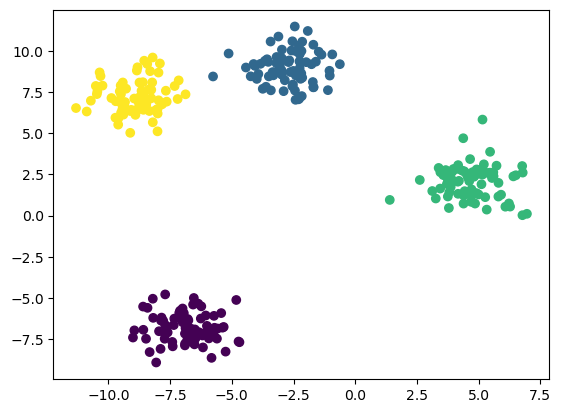

In [83]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# train a model
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

# Use silhouette score to evaluate
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# plot the clusters
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.show()

---

# **Consumer 11.1 - Hoeffding Tree**

### Load baseline model

In [101]:
# Load the baseline model

# folder location and model name
model_folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\ML Models"
model_name = "hoef_model_basic_params.json"
params_path = f"{model_folder_path}\\{model_name}"

with open(params_path, 'r') as file:
    loaded_params = json.load(file)

In [102]:
# Initialize the model
hoef_model_baseline_basic = HoeffdingTree()

# Apply the loaded parameters
hoef_model_baseline_basic.set_params(**loaded_params)

HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                        leaf_prediction='nba', max_byte_size=33554432,
                        memory_estimate_period=1000000, nb_threshold=0,
                        no_preprune=False, nominal_attributes=None,
                        remove_poor_atts=False, split_confidence=1e-07,
                        split_criterion='info_gain', stop_mem_management=False,
                        tie_threshold=0.05)

### Variables needed in notebook

In [107]:
# Location where avro files are saved from the Previous Consumer.
folder_path = r"C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Consumer Data\Avro Batches 2500 avro files"

### Function to send resutls to SQL Database

In [100]:
# create model results transfer to DB funciton.
def insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size):
    
    try: 
        # Connect to the database
        cnx = mysql.connector.connect(**config)
        cursor = cnx.cursor()
    
        # SQL query for iserting data to baseline_model_results
        add_results=("""
            INSERT INTO hoef_basic_rt_model_results
            (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, 
                    %s, %s, %s, %s, %s, %s, %s)
        """)
    
        # Data tuple
        data= (model_name, model_id, model_description, batch_number,
                    accuracy_value, precision_value, recall_value, f1_value, 
                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                    model_training_time, model_paramaters_json, model_size)
    
        # Execute the query
        cursor.execute(add_results, data)
    
        # Commit the transaction
        cnx.commit()
        print("The model results have been inserted successfully")
    
    #except Error as err:
    #    print(f"Error: {err}")
    except mysql.connector.Error as err:
        print(f"Error: {err}")
    
    finally: 
        if cnx.is_connected():
            cursor.close()
            cnx.close()
            print("The Conneciton to MySQL is closed.")


### Consumer - Isolate Forest - Basic Model

In [7]:
############################################################
# Random Froest Basic and Best Consumer Running Model
############################################################
# Set number of batches # CHANGE THIS EACH MODEL
num_batches = 2500
# set inital model as the saved model # CHANGE THIS EACH MODEL
hoef_model_baseline_basic_current_model = hoef_model_baseline_basic

############################################################
# Start Consumer polling
############################################################
# try:
#     while True:
#         msg = consumer.poll(1,0)
        
#         if msg is None:
#             continue
#         if msg.error():
#             print(f"Consumer error: {msg.error()}")
#             continue
                   
############################################################
# Get batches for features and labels
############################################################

#######################
# Set loop to go though batches
for i in range(num_batches):
    features_file = os.path.join(folder_path, f"features_batch_{i}.avro")
    label_file =os.path.join(folder_path, f"label_batch_{i}.avro")
            
    print(f"Processing Batch {i}")
     
    #######################
    # Deserialise the avro files, both features and labels
    
    # Load features batch avro using deserialise funtion
    with open(features_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_features = deserialise_features_avro_record(avro_bytes, features_avro_schema)
            
#         print(f"Loaded features for Batch {i}")
            
    # Load labels batch avro using deserialise funtion
    with open(label_file, "rb") as avro_file:
        avro_bytes = avro_file.read()
        current_labels = deserialise_label_avro_record(avro_bytes, label_avro_schema)
                
#         print(f"Loaded lables for batch {i}")
        
############################################################
# Evaluate Predictions
############################################################
    
    #######################
    #  Get the predictions for the current model with the current features.
    # Extract the labels from the current_label dictionary
    current_labels = [label["Label"] for label in current_labels]

    # use current features for prediction CHANGE THIS EACH MODEL
    loaded_features_array = np.array([list(feature.values()) for feature in current_features])
    predictions = hoef_model_baseline_basic_current_model.predict(loaded_features_array)
    
#     # Print predictions for this batch
#     print(f"Predictions for Batch {i}: {predictions}")
#     #print(f"Labels for Batch {i}: {current_labels}")
    
############################################################
# Results for Database
############################################################
    
    ####################### CHANGE THIS EACH MODEL
    # Model Name - Str
    model_name = f"hoef_model_baseline_basic_batch_{i}"
    
    ####################### CHANGE THIS EACH MODEL
    # Model ID - Str
    model_id = "11.4 - Basic Random Forest" 
    
    #######################  CHANGE THIS EACH MODEL
    # Model Description - Str # To add in more detail while training models
    model_description = "Basic Hoeffding Tree model with 2500 batches."

    #######################
    # Batch Number - Int
    batch_number = i 

    #######################
    # Accuracy Value - Float
    accuracy_value = float(accuracy_score(current_labels, predictions))
    
    #######################
    # Precision Value - Float
    precision_value = float(precision_score(current_labels, predictions))
    
    #######################
    # Recall Value - Float
    recall_value = float(recall_score(current_labels, predictions))
    
    #######################
    # F1 Value - Float
    f1_value = float(f1_score(current_labels, predictions))
    
    #######################
    # AUC Score - Float
    auc_score = float(roc_auc_score(current_labels, predictions))
    
    #######################
    # ROC Curve - JSON
    fpr, tpr, thresholds = roc_curve(current_labels, predictions)
    roc_curve_data = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": thresholds.tolist()
    }
    ruc_curve_json = json.dumps(roc_curve_data)
    
    #######################
    # Confusion Matrix - JSON
    conf_matrix = confusion_matrix(current_labels, predictions) 
    conf_matrix_list = conf_matrix.tolist()
    confusion_matrix_json = json.dumps(conf_matrix_list)
    
############################################################
# Retrain the model with current batch data.
############################################################

    #######################
    # Retrain model
    #######################

    #######################
    # Combine features and labels # change the format to allow retraining
    combined_features = np.array([list(feature.values()) for feature in current_features])
    combined_labels = np.array(current_labels)

    ####################### CHANGE THIS EACH MODEL
    # Retrain model with combined data from current batch
    start_time = time.time() # start of model training
    hoef_model_baseline_basic_current_model.partial_fit(combined_features, combined_labels)
    end_time = time.time() # end of model training

    #######################
    # Additonal items to save
    #######################
    
    #######################  CHANGE THIS EACH MODEL
    # Model feature importance- JSON
    feature_importance_json = None
    
    #######################
    # New model training time
    model_training_time = end_time - start_time   
    
    #######################
    model_paramaters = hoef_model_baseline_basic_current_model.get_params()
    model_paramaters_json =  json.dumps(model_paramaters)
    # model_paramaters_json = ""
    
    #######################
    
    # Get size
    model_size_bytes = None # didnt retrain
    
############################################################
# Second the Data to the Database
############################################################

    # call and save to DB
    insert_model_results_to_db(config, model_name, model_id, model_description, batch_number,
                                    accuracy_value, precision_value, recall_value, f1_value, 
                                    auc_score, ruc_curve_json, confusion_matrix_json, feature_importance_json, 
                                    model_training_time, model_paramaters_json, model_size)
    
    print("\n")

---